In [1]:
%load_ext autoreload
%autoreload 2

## Import Packages

In [2]:
import pandas as pd
import numpy as np
import re
from clean import *

#### Write all csv files in the data folder to text file in current directory

In [3]:
!ls ./data > data.txt

#### Read in data.txt and create dataframe df from raw data

In [4]:
with open('data.txt','r') as f:
    lines = f.readlines()

data = []   
for line in lines:
    data.append(pd.read_csv('./data/'+line[:-1]))

df_raw = pd.concat(data)

#### Clean and generate new columns with clean.py and export cleaned data to csv

In [5]:
df = clean(df_raw)
df.to_csv('data_cleaned.csv')
df.shape
df = df.dropna(subset=['price'])
df.shape

(11813, 19)

(9217, 19)

## Create Transport Dictionary
For every transportation connections pulled in from the listing, I aggregate the speedOfTravel (calculated by dividing the distance by time (converted to hours) to get an estimated measure of traffic/congestion in that area.

In [6]:
# Create an empty list to house the extracted values
lst = []
# Enumerate for every dictionary entry in the transport column
for i,dic in enumerate(df.transport):
    state, city = df.iloc[i][['state','city']]
    city = city + ', ' + state
    for k,v in dic.items():
        lst.append([i, state, city, k, *v])

transport_df = pd.DataFrame(lst, columns=['index','state','city','name','distance','timeTo','speedOfTravel'])

The new dataframe, **transport_df**, preserves the index of the entry it's tied to in the original dataframe, **df**

In [7]:
transport_df.head(5)

,index,state,city,name,distance,timeTo,speedOfTravel
0,0,TX,"Houston, TX",Houston George Bush Intercontinental Airport,10.5,13.0,48.5
1,0,TX,"Houston, TX",William P. Hobby Airport,33.1,46.0,43.2
2,0,TX,"Houston, TX",Port of Houston,25.9,33.0,47.1
3,0,TX,"Houston, TX",UNION PACIFIC BULK TAINER SERVICE-SPRING-TX,4.5,7.0,38.6
4,1,TX,"Houston, TX",Houston George Bush Intercontinental Airport,10.5,13.0,48.5


Create a new dataframe for the average traffic in each city. This dataset contains many cities containing only one warehouse. While at first glance this could be seen to present a problem - we assume that cities with few warehouses probably don't have much traffic regularly and so one or two datapoints in this regard isn't a problem. One warehouse can also have multiple entries listed for nearby transport hubs.

In [8]:
traffic_city = transport_df.groupby(['city']).agg({'city': 'count',
                                                      'distance': 'mean',
                                                      'timeTo' : 'mean',
                                                      'speedOfTravel': 'mean'}).round(0)
traffic_city.columns = ['datapoints','distance','time','speed']

All calculated values are averages. 

Average distance is in miles.

Average travel time to nearest transportation (airport, freight port, railroad, etc.) is in minutes. 

Average speed is in MPH.

All values rounded to nearest unit. 

In [9]:
traffic_city.sample(10)

,datapoints,distance,time,speed
city,,,,
"Jackson, NJ",3,31.0,47.0,39.0
"McHenry, IL",6,266.0,303.0,40.0
"Pine Brook, NJ",6,16.0,26.0,35.0
"Green Bay, WI",9,10.0,20.0,27.0
"New Lenox, IL",17,135.0,156.0,33.0
"Fayetteville, GA",6,90.0,110.0,36.0
"Federalsburg, MD",3,40.0,63.0,36.0
"Lancaster, OH",6,168.0,197.0,45.0
"Nashville, TN",114,98.0,111.0,36.0


Now, lets look for outliers 3 stds away. 

In [10]:
from scipy import stats
traffic_city[np.abs(stats.zscore(traffic_city[['speed']]) > 3).all(axis=1)]

,datapoints,distance,time,speed
city,,,,
"Gillette, WY",3,113.0,120.0,57.0


Basically none! I had a problem earlier with calculated speeds of over 1000 MPH! The problem was many listings had travel time information that simply did not agree with the capabilites of modern automotive engineering. There's no way you can go 20 miles in one minute. I cleaned up that problem in clean.py where I set a maximum speed limit of 75MPH.

<img src="crazySpeed.png">

## Visualization

## State Level Indicators
Here we group on the state level to get similar indications of average speed, distance, and time. It is hoped such data is also useful since most transport hubs are by definition linked to others in the state itself and nearby ones. Another assumption I make is that such networks have been optimzied nationwide so I expect to see not much variation between states in these numbers. 

In [11]:
traffic_state = transport_df.groupby(['state']).agg({'city': 'count',
                                                      'distance': 'mean',
                                                      'timeTo' : 'mean',
                                                      'speedOfTravel': 'mean'}).round(0)
traffic_state.columns = ['datapoints','distance','time','speed']

In [12]:
traffic_state.sample(10)

,datapoints,distance,time,speed
state,,,,
NY,1856,22.0,32.0,33.0
TX,1836,52.0,65.0,39.0
FL,1605,18.0,29.0,33.0
AK,20,168.0,276.0,33.0
ND,45,15.0,24.0,28.0
TN,405,136.0,156.0,39.0
HI,156,9.0,18.0,28.0
KS,412,215.0,255.0,40.0
MO,729,199.0,243.0,38.0


And looking for outliers on the state level:

In [14]:
traffic_state[np.abs(stats.zscore(traffic_state[['speed']]) > 3).all(axis=1)]

,datapoints,distance,time,speed
state,,,,
WY,17,215.0,234.0,50.0


Wyoming again for the win!

### Create airports dataframe from external source for co-location

Use only airports in North America

In [223]:
airports = pd.read_csv('./extra-data/airports.csv', header = None, usecols = [1,2,3,4,6,7,9,10,12],
                       names = ['Name','City','Country','ICAO','Latitude','Longitude','Timezone','DST','Type'])
airports = airports[airports.Country.isin(['United States'])]

## Geocode Function to get Latitutde and Longitude of Each Address

In [224]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

geolocator = Nominatim(country_bias="United States")
def do_geocode(address, attempt=1, max_attempts=5):
    try:
        location = geolocator.geocode(address)
        if location == None:
            return
        
        else:
            return location.latitude, location.longitude
    except GeocoderTimedOut:
        if attempt <= max_attempts:
            return do_geocode(address, attempt=attempt+1)
        raise

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `country_bias` argument of the Nominatim.__init__ is deprecated and will be removed in geopy 2.0. Use Nominatim.geocode(country_codes='United States') instead.
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.


In [443]:
airports[airports.Name.str.contains(r'George Bush')]

,Name,City,Country,ICAO,Latitude,Longitude,Timezone,DST,Type
3362,George Bush Intercontinental Houston Airport,Houston,United States,IAH,29.9844,-95.3414,-6,A,airport


In [416]:
for name in transport_df['Transportation'].sample(100):
    if name in airports.Name:
        print('Found')
    else:
        continue

In [294]:
colFun = {'city' : ['count'],
          'price' : ['min','max','mean','std'],
          'spaceAvailable' : ['min','max','mean','std'],
          'spaces' : ['min','max','mean','std'],
          'subType' : ['count']
         }

In [299]:
df.groupby(['state','city']).agg(colFun).loc['NY']

city  price                           spaceAvailable         \
              count    min   max      mean       std            min    max   
city                                                                         
Brooklyn         34  1.085  5.00  2.645000  1.173551            475  68500   
New York          4  2.250  6.67  4.373333  2.215092           1250  17584   
Staten Island     3  0.830  1.79  1.310000  0.678823           5800  60000   

                                          spaces                          \
                       mean           std    min max      mean       std   
city                                                                       
Brooklyn       14402.382353  15897.758352      1   9  1.882353  1.736676   
New York        9008.500000   8485.031271      1   3  1.750000  0.957427   
Staten Island  27266.666667  28803.009102      1   3  2.333333  1.154701   

              subType  
                count  
city                   
Brooklyn           34  
New York            4  
Staten Island       3

In [367]:
lst = []
for i,dic in enumerate(df.transport):
    for k,v in dic.items():
        lst.append([i,k,*v])

transport_df = pd.DataFrame(lst, columns=['Index','Transportation','Distance','TimeTo','SpeedOfTravel'])

[[0, 'Houston George Bush Intercontinental Airport', 10.5, 13.0, 48.5], [0, 'William P. Hobby Airport', 33.1, 46.0, 43.2], [0, 'Port of Houston', 25.9, 33.0, 47.1], [0, 'UNION PACIFIC BULK TAINER SERVICE-SPRING-TX', 4.5, 7.0, 38.6], [1, 'Houston George Bush Intercontinental Airport', 10.5, 13.0, 48.5], [1, 'William P. Hobby Airport', 33.1, 46.0, 43.2], [1, 'Port of Houston', 25.9, 33.0, 47.1], [1, 'UNION PACIFIC BULK TAINER SERVICE-SPRING-TX', 4.5, 7.0, 38.6], [2, 'William P. Hobby Airport', 5.5, 14.0, 23.6], [2, 'Ellington Field Airport', 10.8, 22.0, 29.5], [2, 'Houston George Bush Intercontinental Airport', 39.1, 45.0, 52.1], [2, 'Port of Houston', 12.8, 23.0, 33.4], [2, 'BNSF-HOUSTON-TX', 5.9, 10.0, 35.4], [3, 'William P. Hobby Airport', 7.2, 18.0, 24.0], [3, 'Ellington Field Airport', 17.6, 32.0, 33.0], [3, 'Houston George Bush Intercontinental Airport', 24.7, 33.0, 44.9], [3, 'Port of Houston', 6.6, 13.0, 30.5], [3, 'GULF WINDS INTERNATIONAL, INC.-MYKAWA-TX', 2.1, 6.0, 21.0], [4, 

In [330]:
df[(~df.spaceSummary.isna()) & (df.spaces > 1)][['buildingSize','spaceAvailable','spaces']]

,buildingSize,spaceAvailable,spaces
963,114450,114450,3
971,82500,29000,3
974,170040,37008,7
979,32200,22050,3
988,74585,5480,2
...,...,...,...
898,48750,1131,2
899,180000,53704,6
903,37567,4000,2
905,420600,72762,4


In [342]:
df_ = df[(df.spaces > 1)][['buildingSize','spaceAvailable','spaces']]
df_['sizeCheck'] = df_.spaceAvailable * df_.spaces
df_['ratio'] = df_.sizeCheck / df_.buildingSize
df_

,buildingSize,spaceAvailable,spaces,sizeCheck,ratio
963,114450,114450,3,343350,3.000000
971,82500,29000,3,87000,1.054545
974,170040,37008,7,259056,1.523500
979,32200,22050,3,66150,2.054348
988,74585,5480,2,10960,0.146946
...,...,...,...,...,...
900,425000,71500,2,143000,0.336471
901,120000,25590,4,102360,0.853000
903,37567,4000,2,8000,0.212953
905,420600,72762,4,291048,0.691983


In [38]:
df_ = df.copy()

In [270]:
def find_height(text):
    height_patterns = [r'([1-3][0-9])\' [Ee]ave', \
            r'([1-3][0-9])\' [Hh]eight',\
            r'([1-3][0-9]) foot',\
            r'([1-3][0-9])\' [Cc]lear', \
            r'([1-3][0-9])\'\s?-([1-3][0-9])\''\
            r'([1-3][0-9])\''
           ]
    for pattern in height_patterns:
        g = re.findall(pattern,text)
        if g:
            if type(g[0]) == tuple:
                return int(g[0][1])
            else:
                return int(g[0])
        return 10
            
def find_driveIn(text):
    drive_patterns = [r'(\d+) [Dd]rive [Ii]n']
    for pattern in drive_patterns:
        g = re.findall(pattern,text)
        if g:
            return int(g[0])
    return 1

            
def find_loading(text):
    drive_patterns = [r'(\d+) [Ll]oading']
    for pattern in drive_patterns:
        g = re.findall(pattern,text)
        if g:
            return int(g[0])
    return 1

In [99]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

geolocator = Nominatim(country_bias="United States")
def do_geocode(address, attempt=1, max_attempts=5):
    try:
        location = geolocator.geocode(address)
        if location == None:
            return
        
        else:
            return location.latitude, location.longitude
    except GeocoderTimedOut:
        if attempt <= max_attempts:
            return do_geocode(address, attempt=attempt+1)
        raise

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `country_bias` argument of the Nominatim.__init__ is deprecated and will be removed in geopy 2.0. Use Nominatim.geocode(country_codes='United States') instead.
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.


In [105]:
for x in set(transport_df['Transportation']):
    if x.upper().find('AIRPORT') != -1:
        print(x)

Charlotte Douglas International Airport
Fairbanks International Airport
University Park Airport
Cherry Capital Airport
Will Rogers World Airport
Reno–Tahoe International Airport
Naples Municipal Airport
Springfield-Branson National Airport
North Las Vegas Airport
Raleigh-Durham International Airport
Newark Liberty International Airport
Lincoln Municipal Airport
University Of Illinois-Willard Airport
T. F. Green Airport
Richmond International Airport
Houston George Bush Intercontinental Airport
Fanning Field Airport
Hilton Head Airport
Central Wisconsin Airport
Tulsa International Airport
Valdosta Regional Airport
Redding Municipal Airport
La Guardia Airport
Dayton International Airport
Tallahassee Regional Airport
Nantucket Memorial Airport
Natrona County International Airport
Klamath Falls International Airport
Eppley Airfield Airport
Greater Binghamtonl-Edwin A. Link Field Airport
Huntsville International-Carl T. Jones Field Airport
Shreveport Regional Airport
McGhee Tyson Airport
Mo

## Test Model for Traffic Score

In [106]:
transport_df.head(10)

,Index,Transportation,Distance,TimeTo,SpeedOfTravel
0,0,Houston George Bush Intercontinental Airport,10.5,13.0,48.5
1,0,William P. Hobby Airport,33.1,46.0,43.2
2,0,Port of Houston,25.9,33.0,47.1
3,0,UNION PACIFIC BULK TAINER SERVICE-SPRING-TX,4.5,7.0,38.6
4,1,Houston George Bush Intercontinental Airport,10.5,13.0,48.5
5,1,William P. Hobby Airport,33.1,46.0,43.2
6,1,Port of Houston,25.9,33.0,47.1
7,1,UNION PACIFIC BULK TAINER SERVICE-SPRING-TX,4.5,7.0,38.6
8,2,William P. Hobby Airport,5.5,14.0,23.6
9,2,Ellington Field Airport,10.8,22.0,29.5


In [113]:
transport_df.groupby('Index').agg({
    'Distance' : 'mean',
    'TimeTo' : 'mean',
    'SpeedOfTravel' : 'mean'})

,Distance,TimeTo,SpeedOfTravel
Index,,,
0,18.500000,24.750000,44.350000
1,18.500000,24.750000,44.350000
2,14.820000,22.800000,34.800000
3,11.640000,20.400000,30.680000
4,27.420000,36.000000,45.760000
...,...,...,...
8612,68.433333,87.333333,38.100000
8613,10.900000,19.666667,32.266667
8614,15.000000,24.000000,37.500000


In [16]:
addresses = df['address'] + ' ' + df['city'] + ' ' + df['state'] + ' ' + 'USA'
lst = []
index=0
for addr in addresses[1212:]:
    if do_geocode(addr):
        print('{}: Not found: '.format(index) + addr)
        print('-'*40)
        lst.append(addr)
    index+=1
print(len(lst))

4: Not found: 10851 Train Ct Houston TX USA
----------------------------------------
29: Not found: 4260-4298 Clark Rd Houston TX USA
----------------------------------------
34: Not found: 4041-4071 Hollister Houston TX USA
----------------------------------------
36: Not found: 11050 W Little York Houston TX USA
----------------------------------------
47: Not found: 6101-6127 Long Dr Houston TX USA
----------------------------------------
49: Not found: 11126-11130 Neeshaw Dr Houston TX USA
----------------------------------------
50: Not found: 9400-9433 Winkler Dr Houston TX USA
----------------------------------------
55: Not found: 14510 Wagg Rd Houston TX USA
----------------------------------------
56: Not found: 14520 Wagg Rd Houston TX USA
----------------------------------------
76: Not found: 5900-5934 S Loop Fwy Houston TX USA
----------------------------------------
91: Not found: 18209-18235 Ammi Trl Houston TX USA
----------------------------------------
92: Not found:

487: Not found: 6610 Bay Cir Norcross GA USA
----------------------------------------
488: Not found: 1412 Battle Creek Rd Jonesboro GA USA
----------------------------------------
489: Not found: 6510 Corporate Ct Alpharetta GA USA
----------------------------------------
490: Not found: 30 Corporate Ct Alpharetta GA USA
----------------------------------------
491: Not found: 7055 Amwiler Industrial Dr NW Atlanta GA USA
----------------------------------------
492: Not found: 935 E Interstate Ridge Dr Gainesville GA USA
----------------------------------------
493: Not found: 3380 Town Point Dr Kennesaw GA USA
----------------------------------------
494: Not found: 300 Adams Jenkins Memorial Dr Canton GA USA
----------------------------------------
495: Not found: 115 Commerce Pky Cornelia GA USA
----------------------------------------
497: Not found: 2205 Northmont Pky Duluth GA USA
----------------------------------------
498: Not found: 175 Chastain Meadows Ct Kennesaw GA USA
--

716: Not found: 5600-5700 Drake Dr SW Atlanta GA USA
----------------------------------------
720: Not found: 101 Old Mackey Rd Woodstock GA USA
----------------------------------------
721: Not found: 103 Old Mackey Rd Woodstock GA USA
----------------------------------------
722: Not found: 105 Old Mackey Rd Woodstock GA USA
----------------------------------------
723: Not found: 107 Old Mackey Rd Woodstock GA USA
----------------------------------------
729: Not found: 1526-1536 Litton Dr Stone Mountain GA USA
----------------------------------------
730: Not found: 7895 Third Flag Pky Austell GA USA
----------------------------------------
731: Not found: 6838 Oak Ridge Commerce Way Austell GA USA
----------------------------------------
733: Not found: 5260 Westgate Dr SW Atlanta GA USA
----------------------------------------
736: Not found: 3075 Chastain Meadows Pky Kennesaw GA USA
----------------------------------------
738: Not found: 6544 Warren Dr Norcross GA USA
---------

911: Not found: 1634 Cobb International Blvd Kennesaw GA USA
----------------------------------------
912: Not found: 1106 Citizens Pkwy Morrow GA USA
----------------------------------------
915: Not found: 1355 McFarland 400 Dr Alpharetta GA USA
----------------------------------------
916: Not found: 3051 N Dug Gap Rd SW Dalton GA USA
----------------------------------------
918: Not found: 825 Progress Center Ave Lawrenceville GA USA
----------------------------------------
920: Not found: 777 SW Oak St Atlanta GA USA
----------------------------------------
924: Not found: 3462-3482 Maggie Blvd Orlando FL USA
----------------------------------------
927: Not found: 3260-3270 SW 11th Ave Fort Lauderdale FL USA
----------------------------------------
928: Not found: 4504 28th St Bradenton FL USA
----------------------------------------
931: Not found: 10117-10187 NW 87th Ave Medley FL USA
----------------------------------------
934: Not found: 2717-2729 E Adamo Dr Tampa FL USA
---

1172: Not found: 3269-3299 SW 42nd Ave Palm City FL USA
----------------------------------------
1175: Not found: 4922 N 113th Ave Clearwater FL USA
----------------------------------------
1177: Not found: 8168-8190 W Baymeadows Way Jacksonville FL USA
----------------------------------------
1180: Not found: 40415 Chancey Rd Zephyrhills FL USA
----------------------------------------
1181: Not found: 1601-1681 NW 79th Ave Doral FL USA
----------------------------------------
1185: Not found: 6236 Kingspointe Pky Orlando FL USA
----------------------------------------
1187: Not found: 2200-2248 Mears Pky Margate FL USA
----------------------------------------
1195: Not found: 5850-5860 Miami Lakes Dr Miami Lakes FL USA
----------------------------------------
1196: Not found: 430-480 27th St Orlando FL USA
----------------------------------------
1200: Not found: 635-655 NW 4th Ave Fort Lauderdale FL USA
----------------------------------------
1204: Not found: 6550 Hazeltine National

GeocoderQuotaExceeded: HTTP Error 429: Too Many Requests

In [88]:
lst

['10851 Train Ct Houston TX USA',
 '4260-4298 Clark Rd Houston TX USA',
 '4041-4071 Hollister Houston TX USA',
 '11050 W Little York Houston TX USA',
 '6101-6127 Long Dr Houston TX USA',
 '11126-11130 Neeshaw Dr Houston TX USA',
 '9400-9433 Winkler Dr Houston TX USA',
 '14510 Wagg Rd Houston TX USA',
 '14520 Wagg Rd Houston TX USA',
 '5900-5934 S Loop Fwy Houston TX USA',
 '18209-18235 Ammi Trl Houston TX USA',
 '5712-5726 Bingle Rd Houston TX USA',
 '9941-9949 Harwin Dr Houston TX USA',
 '211-271B Blue Bell Rd Houston TX USA',
 '2940-3014 Farrell Rd Houston TX USA',
 '8979-8999 Market St Houston TX USA',
 '12228 N Houston Rosslyn Houston TX USA',
 '7301-7401 Security Way Houston TX USA',
 'US 90 & Chimney Rock Houston TX USA',
 '10541 FM 1960 Rd W Houston TX USA',
 '1401-1431 Greengrass Dr Houston TX USA',
 '302-350 W 38th St Houston TX USA',
 '5990-5998 Griggs Rd Houston TX USA',
 '279-309 McCarty St Houston TX USA',
 '7202-7206 Clinton Dr Houston TX USA',
 '6001-6021 S Loop Fwy E Ho

## Visualization Export
Export Data for Visualization

In [98]:
df.sample(4)

,address,amenities,buildingSize,city,listingDate,price,propType,spaceAvailable,spaces,state,subType,transport,utilities,yearBuilt,yearRenovated,ceilingHeight,numDriveIns,numLoadingDocks,propInfo
265,110 Widgeon Dr,None,49800.0,Saint Rose,2019-04-12,0.58,Industrial,13086,1,LA,Office,{'Louis Armstrong New Orleans International Ai...,[],2004,2004,10,1,1,"\nSuite 150 consists of 1,764 SF of office spa..."
550,1531 Indiana Ave,"[Fenced Lot, Floor Drains, Signage, Monument S...",18462.0,Indianapolis,2018-09-08,0.58,Industrial,18462,1,IN,Industrial,"{'Indianapolis International Airport': [13.9, ...","[Heating, Gas, Sewer, Fluorescent, Lighting]",1971,1971,10,1,1,"Creative architecture,Ample natural light,75+ ..."
600,7 Little Wing Ln,"[Signage, Storage Space, Air Conditioning]",10000.0,Gorham,2019-04-22,1.00,Industrial,10000,1,ME,Industrial,{},"[Heating, Sewer, Septic, Well, Lighting]",2019,2019,10,1,1,"New construction– delivered vanilla shell,Loca..."
320,203 Schmid Plaza Rd,None,18000.0,Anderson,2019-07-11,0.29,Industrial,18000,1,SC,Industrial,"{'Georgia Ports - Savannah': [211.9, 287.0, 44...",[],1900,1900,10,1,1,"Located in an established industrial park,Stro..."


### Dataframe of Averages

In [156]:
df_mean = df.groupby(['state']).agg(
    {'price':'mean',
     'spaceAvailable':'mean',
     'address' : 'count'
    })

### Dataframe of Max,Min

In [157]:
floor = 100
df_mean['price'] = df_mean['price'].round(2)
df_mean['spaceAvailable'] = (df_mean['spaceAvailable'] / floor).apply(np.floor).astype(int) *floor
df_mean

,price,spaceAvailable,address
state,,,
AK,1.16,9000,10
AL,0.47,79000,115
AR,0.39,46100,78
AZ,0.78,37600,377
CA,1.23,20400,697
CO,0.85,67500,224
CT,0.72,48400,118
DE,0.70,29600,75
FL,0.92,18900,422


In [160]:
df_mean.to_csv('warehouse_OV.csv')

In [159]:
df_mean

,price,spaceAvailable,address
state,,,
AK,1.16,9000,10
AL,0.47,79000,115
AR,0.39,46100,78
AZ,0.78,37600,377
CA,1.23,20400,697
CO,0.85,67500,224
CT,0.72,48400,118
DE,0.70,29600,75
FL,0.92,18900,422


In [46]:
df_ = pd.read_csv('warehouse_OV.csv')

In [158]:
df_

,address,amenities,buildingSize,city,listingDate,price,propType,spaceAvailable,spaces,state,subType,transport,utilities,yearBuilt,yearRenovated,ceilingHeight,numDriveIns,numLoadingDocks,propInfo
947,1511 FM 1960,"[Bus Line, Fenced Lot, Yard, Storage Space]",12000.0,Houston,2019-05-01,0.85,Industrial,12000,1,TX,Industrial,{'Houston George Bush Intercontinental Airport...,"[Sewer, Lighting]",2019,2019,28,1,1,"12,000sqft Industrial Space,10 ton crane ready..."
948,1515 FM 1960,"[Bus Line, Fenced Lot, Yard, Storage Space]",12000.0,Houston,2019-05-01,0.85,Industrial,12000,1,TX,Industrial,{'Houston George Bush Intercontinental Airport...,"[Sewer, Lighting]",2019,2019,28,1,1,"12,000sqft Industrial Space,28' eave height,Fe..."
949,10800 Blackhawk Blvd,"[Fenced Lot, Fluorescent Lighting, Air Conditi...",42000.0,Houston,2019-05-02,0.45,Industrial,42000,1,TX,Industrial,"{'William P. Hobby Airport': [5.5, 14.0, 23.6]...","[Heating, Sewer, Fluorescent, Lighting]",1985,1985,10,3,1,On a 4 lane street with a left turn insert for...
950,6121 Griggs Rd,[Fenced Lot],39399.0,Houston,2019-05-15,0.85,Industrial,5000,1,TX,Industrial,"{'William P. Hobby Airport': [7.2, 18.0, 24.0]...","[Heating, Gas]",1965,1965,10,1,1,"\n¨ 5,000 sf 100% Office \n¨ Single Tenant \n¨..."
955,10550 Old Bammel N Houston Rd,None,8640.0,Houston,2019-06-10,0.68,Industrial,8640,1,TX,Industrial,{'Houston George Bush Intercontinental Airport...,[],2006,2006,10,1,1,\nThis 8640 square foot property is available ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1209,246 Jacintoport Blvd,None,22400.0,Saraland,2017-03-06,0.63,Industrial,5400,1,AL,Industrial,"{'Mobile Regional Airport': [19.7, 35.0, 33.8]...",[],2003,2003,10,1,4,"(1) dock height door,Skylights,Insulated walls..."
1210,3520-3552 Lorna Ridge Dr,None,12500.0,Birmingham,2019-06-27,0.73,Flex,3240,1,AL,Flex,{'Birmingham-Shuttlesworth International Airpo...,[],1986,1986,10,1,1,"\n±40,365 sf multi-tenant park; Recently renov..."
1211,5155 Mobile South St,None,34000.0,Mobile,2008-12-10,0.38,Industrial,34000,1,AL,Industrial,"{'Mobile Regional Airport': [14.4, 32.0, 27.0]...","[Sewer, Lighting]",2007,2007,10,1,6,"\nLease price includes outside maintenance, wa..."
1212,13800 Mooresville Rd,None,130000.0,Athens,2019-04-08,0.40,Industrial,90000,3,AL,Industrial,{'Huntsville International-Carl T. Jones Field...,[],1999,1999,10,1,1,\n\nListed rate may not include certain utilit...


In [ ]:
df_mean = df.groupby(['state']).agg(
    {'price':'mean',
     'spaceAvailable':'mean',
     'address' : 'count'
    })

In [72]:
import pandas as pd
from sklearn import preprocessing

x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)


ValueError: could not convert string to float: '1511 FM 1960'

In [73]:
df_numerical = df[['buildingSize','price','spaceAvailable']]


In [80]:
import pandas as pd
from sklearn import preprocessing

x = df_numerical.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_numerical = pd.DataFrame(x_scaled, columns=['buildingSize','price','spaceAvailable'])

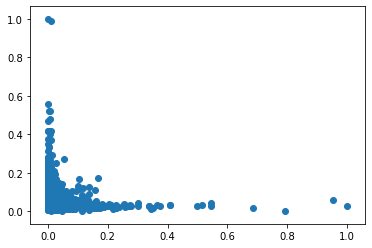

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(df_numerical['spaceAvailable'],df_numerical['price'])

In [166]:
airports = airports[airports.Country=='United States']
ports = airports[airports['Type']=='port']

In [ ]:
airports = 

In [170]:
ports['address'] = ports['Name'] + ' ' + ports['City'] + ' ' + ports['Country']

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [172]:
ports['latlon'] = ports['address'].apply(lambda x: do_geocode(x))

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [182]:
ny.sample(4)

,address,amenities,buildingSize,city,listingDate,price,propType,spaceAvailable,spaces,state,subType,transport,utilities,yearBuilt,yearRenovated,ceilingHeight,numDriveIns,numLoadingDocks,propInfo
136,348 Troutman St,[Commuter Rail],22000.0,Brooklyn,2019-10-17,2.08,Industrial,19499,2,NY,"Office, Industrial",{'Nostrand Avenue Station Commuter Rail (West ...,"[Oil, Heating, Fired]",1931,1931,10,1,1,Block-through between Troutman & Starr Street ...
108,460 Buffalo Rd,"[Bus Line, Fenced Lot, Signage]",488000.0,Rochester,2019-11-14,0.25,Industrial,7604,2,NY,Industrial,{'Greater Rochester International Airport': [4...,[],1965,1965,10,1,1,\nInterior industrial space accessible through...
1363,11-13 Cypress Ave,None,2200.0,Ridgewood,2020-02-27,2.67,Industrial,2200,1,NY,Industrial,{'East New York Station Commuter Rail (West He...,"[Heating, Gas, Sewer, Lighting]",1942,1942,10,1,1,\n2200 sqft warehouse on 2600 sqft lot. 2 year...
52,2099-2101 Mt Read Blvd,"[24 Hour Access, Bus Line, Buss Ducts, Securit...",16710.0,Rochester,2020-01-20,0.46,Industrial,16710,1,NY,Industrial,{'Greater Rochester International Airport': [7...,[],1960,1960,10,1,2,"4,000 SF of clean, air-conditioned manufacturi..."


In [183]:
ny = df[df.state=='NY']

In [184]:
transport_df.sample(3)

,index,state,name,distance,timeTo,speedOfTravel
18623,6507,MD,Wollenweber'S Trucking & Warehousing,1.9,6.0,19.0
7756,2573,OR,Port of Portland,3.8,9.0,25.3
2208,506,NY,Newark Liberty International Airport,19.2,35.0,32.9


In [185]:
transport = pd.merge(transport_df,airports, left_on='name',right_on='Name')

In [187]:
transport[transport.state=='NY']

,index,state,name,distance,timeTo,speedOfTravel,Name,City,Country,ICAO,Latitude,Longitude,Timezone,DST,Type
1006,289,NY,La Guardia Airport,10.3,21.0,29.4,La Guardia Airport,New York,United States,LGA,40.777199,-73.872597,-5,A,airport
1007,290,NY,La Guardia Airport,23.4,40.0,35.1,La Guardia Airport,New York,United States,LGA,40.777199,-73.872597,-5,A,airport
1008,291,NY,La Guardia Airport,12.6,22.0,34.4,La Guardia Airport,New York,United States,LGA,40.777199,-73.872597,-5,A,airport
1009,293,NY,La Guardia Airport,13.6,20.0,40.8,La Guardia Airport,New York,United States,LGA,40.777199,-73.872597,-5,A,airport
1010,296,NY,La Guardia Airport,21.2,35.0,36.3,La Guardia Airport,New York,United States,LGA,40.777199,-73.872597,-5,A,airport
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2609,10713,NY,Buffalo Niagara International Airport,10.2,18.0,34.0,Buffalo Niagara International Airport,Buffalo,United States,BUF,42.940498,-78.732201,-5,A,airport
2610,10714,NY,Buffalo Niagara International Airport,16.8,26.0,38.8,Buffalo Niagara International Airport,Buffalo,United States,BUF,42.940498,-78.732201,-5,A,airport
2611,10715,NY,Buffalo Niagara International Airport,1.8,5.0,21.6,Buffalo Niagara International Airport,Buffalo,United States,BUF,42.940498,-78.732201,-5,A,airport
2612,10716,NY,Buffalo Niagara International Airport,6.8,15.0,27.2,Buffalo Niagara International Airport,Buffalo,United States,BUF,42.940498,-78.732201,-5,A,airport


In [268]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from time import sleep
geolocator = Nominatim(country_bias="United States")
def do_geocode(address, attempt=1, max_attempts=5):
    try:
        location = geolocator.geocode(address)
        if location == None:
            return
        
        else:
            sleep(1)
            return location.latitude, location.longitude
    except GeocoderTimedOut:
        if attempt <= max_attempts:
            return do_geocode(address, attempt=attempt+1)
        raise

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `country_bias` argument of the Nominatim.__init__ is deprecated and will be removed in geopy 2.0. Use Nominatim.geocode(country_codes='United States') instead.
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.


In [232]:
def geocode(address):
    try:
        results = geocoder.geocode(address)
        if results and len(results):
            return results[0]['geometry']
    except RateLimitExceededError as ex:
        pass

In [434]:
df = df_.copy()
df

,address,amenities,buildingSize,city,listingDate,price,propType,spaceAvailable,spaces,state,subType,transport,utilities,yearBuilt,yearRenovated,ceilingHeight,numDriveIns,numLoadingDocks,propInfo
947,"1511 FM 1960 Houston, TX USA","[Bus Line, Fenced Lot, Yard, Storage Space]",12000.0,Houston,2019-05-01,0.85,Industrial,12000,1,TX,Industrial,{'Houston George Bush Intercontinental Airport...,"[Sewer, Lighting]",2019,2019,28,1,1,"12,000sqft Industrial Space,10 ton crane ready..."
948,"1515 FM 1960 Houston, TX USA","[Bus Line, Fenced Lot, Yard, Storage Space]",12000.0,Houston,2019-05-01,0.85,Industrial,12000,1,TX,Industrial,{'Houston George Bush Intercontinental Airport...,"[Sewer, Lighting]",2019,2019,28,1,1,"12,000sqft Industrial Space,28' eave height,Fe..."
949,"10800 Blackhawk Blvd Houston, TX USA","[Fenced Lot, Fluorescent Lighting, Air Conditi...",42000.0,Houston,2019-05-02,0.45,Industrial,42000,1,TX,Industrial,"{'William P. Hobby Airport': [5.5, 14.0, 23.6]...","[Heating, Sewer, Fluorescent, Lighting]",1985,1985,10,3,1,On a 4 lane street with a left turn insert for...
950,"6121 Griggs Rd Houston, TX USA",[Fenced Lot],39399.0,Houston,2019-05-15,0.85,Industrial,5000,1,TX,Industrial,"{'William P. Hobby Airport': [7.2, 18.0, 24.0]...","[Heating, Gas]",1965,1965,10,1,1,"\n¨ 5,000 sf 100% Office \n¨ Single Tenant \n¨..."
955,"10550 Old Bammel N Houston Rd Houston, TX USA",None,8640.0,Houston,2019-06-10,0.68,Industrial,8640,1,TX,Industrial,{'Houston George Bush Intercontinental Airport...,[],2006,2006,10,1,1,\nThis 8640 square foot property is available ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1209,"246 Jacintoport Blvd Saraland, AL USA",None,22400.0,Saraland,2017-03-06,0.63,Industrial,5400,1,AL,Industrial,"{'Mobile Regional Airport': [19.7, 35.0, 33.8]...",[],2003,2003,10,1,4,"(1) dock height door,Skylights,Insulated walls..."
1210,"3520-3552 Lorna Ridge Dr Birmingham, AL USA",None,12500.0,Birmingham,2019-06-27,0.73,Flex,3240,1,AL,Flex,{'Birmingham-Shuttlesworth International Airpo...,[],1986,1986,10,1,1,"\n±40,365 sf multi-tenant park; Recently renov..."
1211,"5155 Mobile South St Mobile, AL USA",None,34000.0,Mobile,2008-12-10,0.38,Industrial,34000,1,AL,Industrial,"{'Mobile Regional Airport': [14.4, 32.0, 27.0]...","[Sewer, Lighting]",2007,2007,10,1,6,"\nLease price includes outside maintenance, wa..."
1212,"13800 Mooresville Rd Athens, AL USA",None,130000.0,Athens,2019-04-08,0.40,Industrial,90000,3,AL,Industrial,{'Huntsville International-Carl T. Jones Field...,[],1999,1999,10,1,1,\n\nListed rate may not include certain utilit...


In [244]:
df['latlon'] = df['address'].apply(lambda x: geocode(x))

In [261]:
df_proc = df[df.latlon.isna()][['address']]

In [265]:
for addr in df_proc[:3]:
    print(do_geocode(addr))

(-37.90323075, 144.758564914636)


In [318]:
step=100
for n in range(0,1):
    temp = df_proc['address'][n*step:(n+1)*step].apply(lambda x: do_geocode(x))
    latlon.append(temp)
    sleep(10)

In [425]:
a = pd.concat(latlon)

In [426]:
a = a.reset_index()

In [427]:
a.columns = ['index','coords']

In [428]:
a = a.drop_duplicates(subset='index')

In [429]:
df_latlon = pd.merge(df_proc,a,on='index',how='left')

In [430]:
df_latlon

,level_0,index,address,coords
0,0,306,"16150 W Lincoln Ave New Berlin, WI USA","(43.00274132258065, -88.11424972580646)"
1,1,323,"8100 N Teutonia Ave Milwaukee, WI USA","(43.110111, -87.949486)"
2,2,324,"275 Bruce St Verona, WI USA","(42.97803720298252, -89.54016636718835)"
3,3,326,"1335 Plainview Dr Oshkosh, WI USA",None
4,4,327,"Enterprise Dr Sturtevant, WI USA","(42.7139321, -87.9082566)"
...,...,...,...,...
6729,6729,1209,"246 Jacintoport Blvd Saraland, AL USA","(30.804928291666666, -88.069106375)"
6730,6730,1210,"3520-3552 Lorna Ridge Dr Birmingham, AL USA","(42.13542545, -71.07250484319789)"
6731,6731,1211,"5155 Mobile South St Mobile, AL USA","(39.7743726, -104.7481278)"
6732,6732,1212,"13800 Mooresville Rd Athens, AL USA","(34.756419, -86.877171)"


In [399]:
df['coords'] = df['latlon'].apply(lambda x: changeLatLon(x))

In [396]:
def changeLatLon(x):
    if x:
        return x['lat'],x['lng']
    else:
        return

In [435]:
pd.merge(df, df_latlon[['address','coords']], on='address', how='left')

,address,amenities,buildingSize,city,listingDate,price,propType,spaceAvailable,spaces,state,subType,transport,utilities,yearBuilt,yearRenovated,ceilingHeight,numDriveIns,numLoadingDocks,propInfo,coords
0,"1511 FM 1960 Houston, TX USA","[Bus Line, Fenced Lot, Yard, Storage Space]",12000.0,Houston,2019-05-01,0.85,Industrial,12000,1,TX,Industrial,{'Houston George Bush Intercontinental Airport...,"[Sewer, Lighting]",2019,2019,28,1,1,"12,000sqft Industrial Space,10 ton crane ready...",NaN
1,"1515 FM 1960 Houston, TX USA","[Bus Line, Fenced Lot, Yard, Storage Space]",12000.0,Houston,2019-05-01,0.85,Industrial,12000,1,TX,Industrial,{'Houston George Bush Intercontinental Airport...,"[Sewer, Lighting]",2019,2019,28,1,1,"12,000sqft Industrial Space,28' eave height,Fe...",NaN
2,"10800 Blackhawk Blvd Houston, TX USA","[Fenced Lot, Fluorescent Lighting, Air Conditi...",42000.0,Houston,2019-05-02,0.45,Industrial,42000,1,TX,Industrial,"{'William P. Hobby Airport': [5.5, 14.0, 23.6]...","[Heating, Sewer, Fluorescent, Lighting]",1985,1985,10,3,1,On a 4 lane street with a left turn insert for...,NaN
3,"6121 Griggs Rd Houston, TX USA",[Fenced Lot],39399.0,Houston,2019-05-15,0.85,Industrial,5000,1,TX,Industrial,"{'William P. Hobby Airport': [7.2, 18.0, 24.0]...","[Heating, Gas]",1965,1965,10,1,1,"\n¨ 5,000 sf 100% Office \n¨ Single Tenant \n¨...",NaN
4,"10550 Old Bammel N Houston Rd Houston, TX USA",None,8640.0,Houston,2019-06-10,0.68,Industrial,8640,1,TX,Industrial,{'Houston George Bush Intercontinental Airport...,[],2006,2006,10,1,1,\nThis 8640 square foot property is available ...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9594,"3520-3552 Lorna Ridge Dr Birmingham, AL USA",None,12500.0,Birmingham,2019-06-27,0.73,Flex,3240,1,AL,Flex,{'Birmingham-Shuttlesworth International Airpo...,[],1986,1986,10,1,1,"\n±40,365 sf multi-tenant park; Recently renov...","(42.13542545, -71.07250484319789)"
9595,"5155 Mobile South St Mobile, AL USA",None,34000.0,Mobile,2008-12-10,0.38,Industrial,34000,1,AL,Industrial,"{'Mobile Regional Airport': [14.4, 32.0, 27.0]...","[Sewer, Lighting]",2007,2007,10,1,6,"\nLease price includes outside maintenance, wa...","(39.77433677944124, -104.94516891303088)"
9596,"5155 Mobile South St Mobile, AL USA",None,34000.0,Mobile,2008-12-10,0.38,Industrial,34000,1,AL,Industrial,"{'Mobile Regional Airport': [14.4, 32.0, 27.0]...","[Sewer, Lighting]",2007,2007,10,1,6,"\nLease price includes outside maintenance, wa...","(39.7743726, -104.7481278)"
9597,"13800 Mooresville Rd Athens, AL USA",None,130000.0,Athens,2019-04-08,0.40,Industrial,90000,3,AL,Industrial,{'Huntsville International-Carl T. Jones Field...,[],1999,1999,10,1,1,\n\nListed rate may not include certain utilit...,"(34.756419, -86.877171)"


In [436]:
df.loc[df.coords.isna()]['coords'] = df_latlon['coords']

AttributeError: 'DataFrame' object has no attribute 'coords'

In [420]:
temp = df[['address','coords','state']][~df['coords'].isna()]

In [422]:
temp.groupby(['state']).agg({'address': 'count'})

,address
state,
CA,33
IL,10
NC,303
ND,39
NM,25
NY,386
OH,427
OK,163
OR,210


In [424]:
df

,name,pop,lat,lon,text
0,New York,8287238,40.730599,-73.986581,New York <br>Population 8.287238 million
1,Los Angeles,3826423,34.053717,-118.242727,Los Angeles <br>Population 3.826423 million
2,Chicago,2705627,41.875555,-87.624421,Chicago <br>Population 2.705627 million
3,Houston,2129784,29.758938,-95.367697,Houston <br>Population 2.129784 million
4,Philadelphia,1539313,39.952335,-75.163789,Philadelphia <br>Population 1.539313 million
...,...,...,...,...,...
3223,Spanish Fort,7102,30.674913,-87.915272,Spanish Fort <br>Population 0.007102 million
3224,Plaquemine,7102,30.289083,-91.234274,Plaquemine <br>Population 0.007102 million
3225,Milton-Freewater,7102,45.932635,-118.387743,Milton-Freewater <br>Population 0.007102 million
3226,Benton,7096,36.034529,-88.101285,Benton <br>Population 0.007096 million
